In [21]:
import pandas as pd
import numpy as np

from google.colab import drive
import os
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from sklearn.ensemble import IsolationForest

In [22]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [23]:
class Preprocessing:
  def __init__(self, path):
    self.path = path
  
  def sync_data_without_duplicate(self):
    raw_data = None
    for root, dirs, files in os.walk(self.path):
      for filename in files:
        data_file = pd.read_csv(path + '/' + filename)
        raw_data = pd.concat([raw_data,data_file]).drop_duplicates().reset_index(drop=True)
    return raw_data

  def split_timestamp(self, data):
    data = data.rename(columns={'@timestamp': 'timestamp'})
    data['timestamp'] = data.timestamp.str.lstrip("	")
    abbr_to_num = {name: num for num, name in enumerate(calendar.month_abbr) if num}
    data['month'] = data['timestamp'].str[:3]
    data['month'].replace(abbr_to_num, inplace=True)
    data['timestamp'] = data['timestamp'].str[4:]
    data['day'] = data['timestamp'].str[:2]
    data['day'] = data.day.str.rstrip(",")
    data['timestamp'] = data['timestamp'].str[:8:-1]
    data['timestamp'] = data['timestamp'].str[::-1].str.strip("@ ")
    data['minutes'] = (data['timestamp'].str[:2].astype(int)*60) + (data['timestamp'].str[3:5].astype(int))
    data['hour'] = data['timestamp'].str[:2].astype(int)
    data['half_hour'] = ((data['timestamp'].str[:2].astype(int)*60) + (data['timestamp'].str[3:5].astype(int)))//30
    data['quatre_hour'] = ((data['timestamp'].str[:2].astype(int)*60) + (data['timestamp'].str[3:5].astype(int)))//15
    data['five_minutes'] = ((data['timestamp'].str[:2].astype(int)*60) + (data['timestamp'].str[3:5].astype(int)))//5

    data['updated'] = data['updated'].str[:10:-1].str[::-1]
    data['updated'] = (data['updated'].str[:2].astype(int)*60) + (data['updated'].str[3:5].astype(int))
    return data

  def add_diff_feature(self, data):
    diff = data['updated'] - data['minutes']
    diff = diff.apply(lambda x: (x+1440) if x < 0 else x)
    data.insert(1, "diff", diff)
    return data

  def remove_unwanted_features(self, data, list_unwanted):
    data = data.drop(list_unwanted, axis=1)
    return data

  def choose_wanted_features(self, data, list_wanted):
    data = data[list_wanted]
    return data

In [24]:
def Preprocessor(path):
  list_wanted = ["_id" ,"diff", "alert.description", "host.name", "hour", "half_hour", "quatre_hour", "five_minutes", "minutes"]
  preprocessing = Preprocessing(path)
  data = preprocessing.sync_data_without_duplicate()
  data = preprocessing.split_timestamp(data)
  data = preprocessing.add_diff_feature(data)
  data = preprocessing.choose_wanted_features(data, list_wanted)
  return data

In [25]:
path = '/content/drive/MyDrive/ekron_data'
data = Preprocessor(path)
data

,_id,diff,alert.description,host.name,hour,half_hour,quatre_hour,five_minutes,minutes
0,96895960,0,Interface ge-0/0/15(): Ethernet has changed to...,SW_Smilanski_24P,7,15,30,90,453
1,96895857,0,High ICMP ping loss,siklu_junc6_to_junc7,7,15,30,90,453
2,96895833,0,Interface ge-0/0/6(): Link down,Security-HR-Environment_4DC-SW1,7,15,30,90,453
3,96895818,0,Interface ge-0/0/37(): Link down,Engineering-management_Floor_5-SW3,7,15,30,90,453
4,96895783,0,High ICMP ping loss,siklu_police_pais_to_junc7,7,15,30,90,452
...,...,...,...,...,...,...,...,...,...
98296,115923256,1,Ekron monitor history syncer processes more th...,Ekron Monitor System,10,20,40,120,602
98297,115923303,46,Ekron monitor escalator processes more than 75...,Ekron Monitor System,10,20,40,120,602
98298,115922086,10,High ICMP ping loss,NVR-junc30,9,19,39,118,592
98299,115922077,10,High ICMP ping loss,sw-junc30,9,19,39,118,592


In [26]:
path = '/content/drive/MyDrive/prediction_data'
data_to_predict = Preprocessor(path)
data_to_predict

,_id,diff,alert.description,host.name,hour,half_hour,quatre_hour,five_minutes,minutes
0,120226584,0,Asset Unavilable,junc1-cam4,8,16,32,97,486
1,120226451,0,Asset Unavilable,junc1-cam3,8,16,32,97,486
2,120226427,0,Asset Unavilable,junc1-cam2,8,16,32,97,486
3,120226416,0,Asset Unavilable,camera1-junc_bnei_moshe,8,16,32,97,486
4,120226155,0,Asset Unavilable,junc1-cam1,8,16,32,97,486
...,...,...,...,...,...,...,...,...,...
5762,119681912,13,Interface ge-0/0/2(): Ethernet has changed to ...,Floor6_SW3_PRINTERS,10,21,43,130,653
5763,119681873,12,Interface ge-0/0/34(): Ethernet has changed to...,Floor_3_SW_printer_32,10,21,43,130,653
5764,119681872,12,Interface ge-0/0/27(): Ethernet has changed to...,Floor_3_SW_printer_32,10,21,43,130,653
5765,119681867,12,Interface ge-0/0/21(): Ethernet has changed to...,Treasurer-Institutions_Floor_SW3,10,21,43,130,653


In [27]:
class Visualization:

  def __init__(self, all_data, time_period):
    self.data = all_data
    self.time_period = time_period

  def alert_count_each_type(self):
    count = self.data.groupby("alert.description").count()["host.name"].sort_values(ascending=False)
    count = pd.DataFrame(data=count)
    count = count.rename(columns={'host.name': 'count'})
    print(count.head(50))

  def element_to_visualize(self, col, element):
    return self.data[self.data[col] == element]

  def time_of_alert_vs_time_until_fix_plot(self, data, title):
    plt.scatter(data['minutes'], data['diff'])
    plt.ylabel('alert time until fix')
    plt.xlabel('alert minute in the day')
    plt.title('time of alert vs time until fix')
    plt.show()

  def how_many_alerts_every_time_period_plot(self, data):
    timeline = data.groupby(pd.Grouper(key= self.time_period)).size()
    timeline.sort_index().plot.bar(figsize=(18,6))
    plt.ylabel('alert Count')
    plt.title('amount of alerts in every ' + self.time_period)
    plt.grid(True)
    plt.show()

  def density_alert_time_and_time_until_fix_plot(self, data, element):
    fig, axs = plt.subplots(2, 1, figsize=(12,6), constrained_layout=True)          
       
    sns.distplot(ax = axs[0], x = data[self.time_period], color = "green", bins = 20)      
    axs[0].set_title(element + ' - ' + self.time_period)

    sns.distplot(ax = axs[1], x = data['diff'], color = "green", bins = 20)      
    axs[1].set_title(element +' - time until fix')
    plt.show()

  def correlation_and_covariance_plot(self, cor, title):
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(cor, dtype=bool))
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(cor, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}).set(title = title)
    
  def call_corcov_plot(self, data):
    self.correlation_and_covariance_plot(data.corr(), "correlation")
    self.correlation_and_covariance_plot(data.cov(), "covariance")
  
  def execute_plots(self, col, element):
    data = self.element_to_visualize(col, element)
    print(data.describe())
    self.alert_count_each_type()
    self.time_of_alert_vs_time_until_fix_plot(data, element)
    self.how_many_alerts_every_time_period_plot(data)
    self.density_alert_time_and_time_until_fix_plot(data, element)
    self.call_corcov_plot(data)

                _id        diff        hour  half_hour  quatre_hour  \
count  2.250000e+02  225.000000  225.000000  225.00000   225.000000   
mean   9.466970e+07   20.373333   11.675556   23.84000    48.244444   
std    6.007366e+06   10.878928    6.290340   12.59752    25.173466   
min    9.043102e+07    0.000000    0.000000    0.00000     1.000000   
25%    9.217635e+07   15.000000    6.000000   13.00000    27.000000   
50%    9.324482e+07   18.000000   12.000000   24.00000    49.000000   
75%    9.479468e+07   24.000000   16.000000   33.00000    67.000000   
max    1.197882e+08   85.000000   23.000000   47.00000    95.000000   

       five_minutes      minutes  
count    225.000000   225.000000  
mean     145.840000   732.053333  
std       75.536008   377.743473  
min        4.000000    20.000000  
25%       83.000000   419.000000  
50%      148.000000   744.000000  
75%      202.000000  1013.000000  
max      287.000000  1438.000000  
                                             

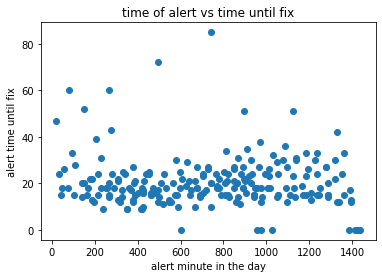

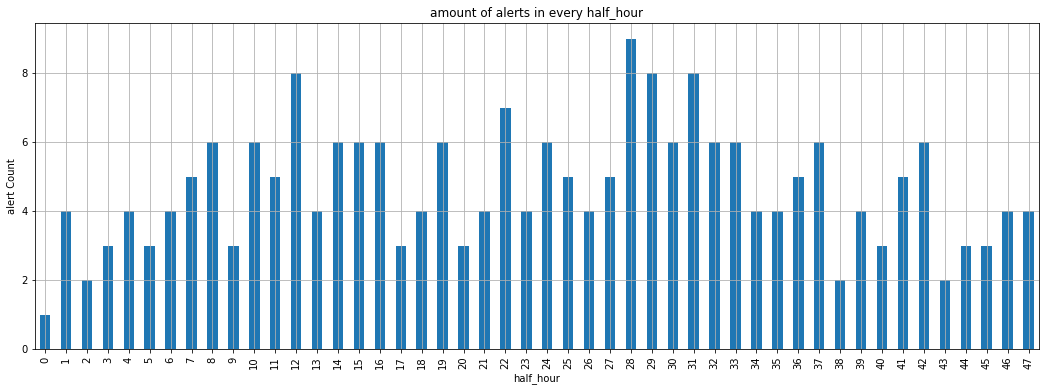

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


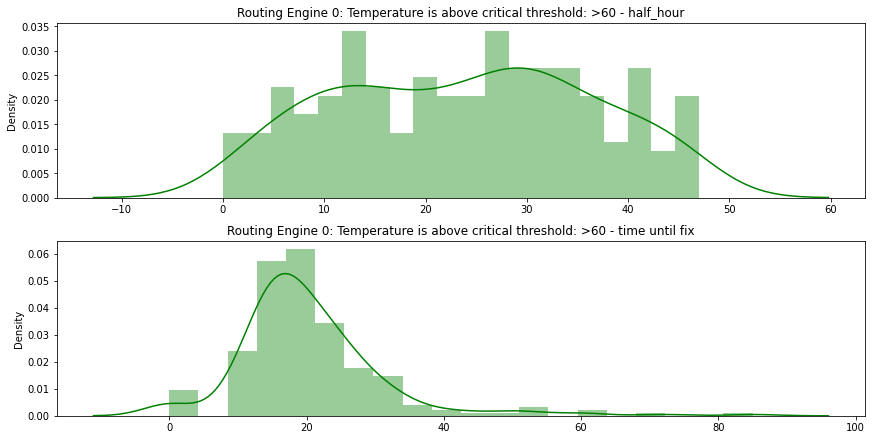

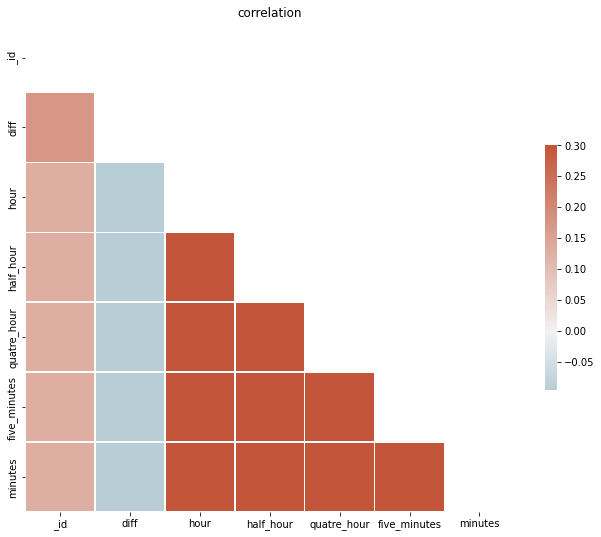

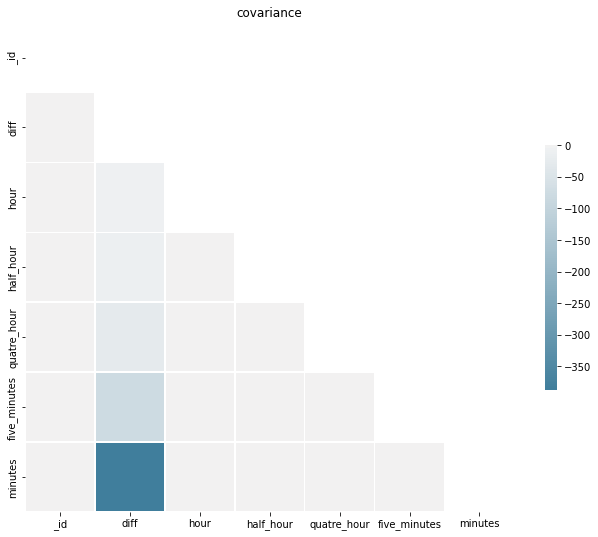

In [28]:
v = Visualization(data, 'half_hour')
v.execute_plots('alert.description', 'Routing Engine 0: Temperature is above critical threshold: >60')

In [29]:
class Anomaly_Detection:

  def __init__(self, history, current):
    self.history = history
    self.current = current
    self.remove_outliers('diff')

  def get_upper_outlier(self, column, std_threshold):
    mean = column.mean()
    sd = column.std()
    bound = sd * std_threshold
    upper_bound = mean + bound
    return upper_bound

  def remove_outliers(self, column):
    upper_bound = self.get_upper_outlier(self.history[column], 2)
    self.history.loc[self.history[column] > upper_bound, column ] = upper_bound
    return self.history

  def normalization(self, column):
    mean = column.mean()
    std = column.std()
    normalized_column = (column - mean) / std
    return normalized_column

  def calculate_score(self, data_score, time='quatre_hour', pdf_weight=1, diff_weight=1, mean_alert_length_period_weight=1):
    pdf = 0
    mean_alert_length_period = 0
    count_by_time = 0
    score = 0
    alerts_length = 0
    alerts_length_with_period = 0

    count_by_time = data_score.groupby([time]).size()
    count_by_time = data_score[time].apply(lambda x: count_by_time[x])
    pdf = 1 - (count_by_time / data_score.groupby(pd.Grouper(key=time)).size().sum())
    mean_length = data_score.groupby([time])['diff'].mean()
    mean_alert_length_period = data_score[time].apply(lambda x: mean_length[x])

    pdf = self.normalization(pdf)
    alerts_length = self.normalization(data_score['diff'])
    alerts_length_with_period = data_score['diff'] - mean_alert_length_period

    score = (pdf * pdf_weight) + (alerts_length * diff_weight) + ((alerts_length_with_period) * mean_alert_length_period_weight)
    return score

  def check_if_notify_alerts_by_type(self, time='quatre_hour', pdf_weight=1, diff_weight=1, mean_alert_length_period_weight=1):
    all_alerts_to_notify = pd.DataFrame()
    check_alerts_descriptions = self.current.groupby('alert.description').groups.keys()
    self.current['to_check'] = True
    self.history['to_check'] = False

    for alert_type in check_alerts_descriptions:
      history_by_type = self.history[self.history['alert.description'] == alert_type]
      current_by_type = self.current[self.current['alert.description'] == alert_type]
      history_scores = self.calculate_score(history_by_type, time, pdf_weight, diff_weight, mean_alert_length_period_weight)
      bound = self.get_upper_outlier(history_scores, 2)

      history_and_current_by_type = pd.concat([history_by_type,current_by_type]).reset_index(drop=True)
      history_and_current_by_type['score'] = self.calculate_score(history_and_current_by_type, time, pdf_weight, diff_weight, mean_alert_length_period_weight)

      alerts_to_check_scores = history_and_current_by_type[history_and_current_by_type['to_check'] == True]
      alerts_to_notify = alerts_to_check_scores[alerts_to_check_scores['score'] > bound]
      all_alerts_to_notify = all_alerts_to_notify.append(alerts_to_notify, ignore_index=True)
    return all_alerts_to_notify


In [30]:
def notify_by_host(all_data, all_data_to_predict, host):
  data_by_host = all_data[all_data['host.name'] == host]
  data_by_host_to_predict = all_data_to_predict[all_data_to_predict['host.name'] == host]
  anomaly_detection = Anomaly_Detection(data_by_host, data_by_host_to_predict)
  alert_to_notify_by_type = anomaly_detection.check_if_notify_alerts_by_type()
  return alert_to_notify_by_type

In [31]:
notify_by_host(data, data_to_predict, 'Links_Floor_7_SW1')

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,_id,diff,alert.description,host.name,hour,half_hour,quatre_hour,five_minutes,minutes,to_check,score
0,119836292,61.0,FPC: EX4300-32F @ 0/*/*: Temperature is above ...,Links_Floor_7_SW1,16,33,67,203,1018,True,35.643040
1,119788233,51.0,FPC: EX4300-32F @ 0/*/*: Temperature is above ...,Links_Floor_7_SW1,14,29,59,179,898,True,21.780591
2,119836293,61.0,Routing Engine 0: Temperature is above critica...,Links_Floor_7_SW1,16,33,67,203,1018,True,35.644465
3,119788234,51.0,Routing Engine 0: Temperature is above critica...,Links_Floor_7_SW1,14,29,59,179,898,True,21.781662


In [32]:
def all_to_notify(all_data, all_data_to_predict):
  all_alerts_hosts = all_data_to_predict.groupby('host.name').groups.keys()
  all_to_notify = pd.DataFrame()
  for host in all_alerts_hosts:
    alert_to_notify_by_type = pd.DataFrame()
    data_by_host = pd.DataFrame(all_data[all_data['host.name'] == host])
    data_by_host_to_predict = pd.DataFrame(all_data_to_predict[all_data_to_predict['host.name'] == host])
    anomaly_detection = Anomaly_Detection(data_by_host, data_by_host_to_predict)
    alert_to_notify_by_type = anomaly_detection.check_if_notify_alerts_by_type()
    all_to_notify = all_to_notify.append(alert_to_notify_by_type, ignore_index=True)
  return all_to_notify

In [33]:
all_to_notify(data, data_to_predict)

,_id,diff,alert.description,host.name,hour,half_hour,quatre_hour,five_minutes,minutes,to_check,score
0,119943156,44.0,More than 95% used in the value cache,Ekron Monitor System,20,41,82,246,1232,True,19.014426
1,119914003,44.0,More than 95% used in the value cache,Ekron Monitor System,19,39,78,234,1171,True,23.482654
2,119885760,48.0,More than 95% used in the value cache,Ekron Monitor System,18,37,74,222,1110,True,24.412955
3,119974733,36.0,Interface ge-0/0/16(): Ethernet has changed to...,Floor_3_SW_printer_32,21,43,87,263,1318,True,25.179260
4,119783245,42.0,Interface ge-0/0/16(): Ethernet has changed to...,Floor_3_SW_printer_32,14,28,57,171,856,True,22.977692
...,...,...,...,...,...,...,...,...,...,...,...
90,120044946,8.0,Interface Eth2(): Link down,siklu_metamiteiman_to_moria,1,2,4,12,64,True,6.533788
91,119788964,8.0,Interface Eth2(): Link down,siklu_metamiteiman_to_moria,15,30,60,180,904,True,5.433815
92,119861468,24.0,High ICMP ping loss,sw-junc6,17,35,71,213,1069,True,11.977917
93,119730704,6.0,Unable to retrive data from asset,sw_junc223,12,25,50,151,757,True,10.403398
